In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'CMSC828C/Project 2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CMSC828C/Project 2


In [2]:
import torch
import numpy as np
import random
from random import shuffle
from pathlib import Path
import os

import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T,datasets
import torchvision

import torch.nn as nn
import torch.nn.functional as F

In [3]:
train_dir = Path("/content/drive/MyDrive/CMSC828C/Project 2/Datasets/Monkey/training/training")
test_dir = Path("/content/drive/MyDrive/CMSC828C/Project 2/Datasets/Monkey/validation/validation")

print(os.listdir(train_dir))
print(os.listdir(test_dir))

['n9', 'n2', 'n8', 'n0', 'n1', 'n7', 'n6', 'n5', 'n4', 'n3']
['n0', 'n9', 'n3', 'n7', 'n1', 'n6', 'n8', 'n2', 'n4', 'n5']


In [4]:
train_tranform = T.Compose([T.Resize(size=(224,224)),T.ToTensor()])
val_tranform = T.Compose([T.Resize(size=(224,224)),T.ToTensor()])



#data augmentation for the train and test
train_data = ImageFolder(train_dir,       
                    transform=train_tranform)
val_data = ImageFolder(test_dir,
                    transform=val_tranform)

In [5]:
batch_size = 16
loader_train = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
loader_val = DataLoader(val_data , batch_size , num_workers=2,pin_memory=True)

In [31]:
print(len(loader_train.dataset.targets))
print(len(loader_train.dataset.imgs))
print(len(loader_val.dataset.targets))
print(len(loader_val.dataset.imgs))

1097
1097
272
272


torch.Size([3, 224, 224]) 3


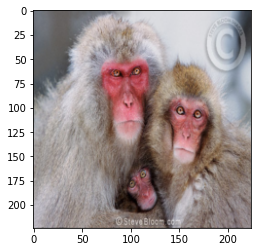

In [7]:
import matplotlib.pyplot as plt
X, y = val_data[100]
print(X.shape, y)
plt.imshow(X.cpu().detach().numpy().transpose(1,2,0), cmap='brg')
plt.show()

In [8]:
class my_model(nn.Module):
  def __init__(self):
    super(my_model,self).__init__()
    
    layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=5, stride = 1, padding=0), # 16 x 220 x 220
        nn.GroupNorm(2, 16),
        nn.ReLU()
    )

    layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride = 1, padding=1), # 32 x 220 x 220
        nn.GroupNorm(4, 32),
        nn.ReLU(),
        nn.MaxPool2d(2) # 32 x 110 x 110
    )

    layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=5, stride = 1, padding=1), # 64 x 108 x 108
        nn.GroupNorm(8, 64),
        nn.ReLU() 
    )

    layer4 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride = 1, padding=1), # 128 x 108 x 108
        nn.GroupNorm(16, 128),
        nn.ReLU(),
        nn.MaxPool2d(2) # 128 x 54 x 54
    )

    layer5 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=5, stride = 1, padding=0), # 256 x 50 x 50
        nn.GroupNorm(32, 256),
        nn.ReLU(),
        nn.MaxPool2d(2) # 256 x 25 x 25
    )





    self.model = nn.Sequential(
        layer1,
        layer2,
        layer3,
        layer4,
        layer5,
        nn.Flatten(),
        nn.Linear(256*25*25, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self,x):
    return self.model(x)




    


model = my_model()
model

my_model(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): GroupNorm(2, 16, eps=1e-05, affine=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 32, eps=1e-05, affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(16, 128, eps=1e-05, affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
      (1): GroupNorm(32, 256,

In [9]:
#train the network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.001
model = model.to(device)
cost_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

total_steps = len(train_data)

In [12]:
num_epochs = 5
for epoch in range(num_epochs):
  model.train()
  history = []
  train_losses = []
  for X_train, y_train in loader_train:
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    outputs = model(X_train)
    losses = cost_function(outputs , y_train)
    train_losses.append(losses)
    losses.backward()
    optimizer.step()
    optimizer.zero_grad()
  print("Epoch [{}/{}]],Loss:{:.4f}".format(epoch+1, num_epochs, losses.item()))
                

Epoch [1/5]],Loss:2.2653
Epoch [2/5]],Loss:2.7251
Epoch [3/5]],Loss:1.8089
Epoch [4/5]],Loss:1.9122
Epoch [5/5]],Loss:1.3691


In [13]:
# validate
with torch.no_grad():
  total , correct = 0 , 0 
  for batch in loader_val:
    model.eval()
    # print(batch[1])
    images , labels = batch
    # print(image.shape , labels)
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    _,predicted = torch.max(output.data,1)
    # print(predicted)
    # print(labels)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    print("Correct :",correct)
  print("Accuracy of model: {} %".format(100*correct/total))

Correct : 5
Correct : 12
Correct : 21
Correct : 23
Correct : 26
Correct : 31
Correct : 35
Correct : 39
Correct : 44
Correct : 48
Correct : 53
Correct : 58
Correct : 66
Correct : 71
Correct : 75
Correct : 81
Correct : 91
Accuracy of model: 33.455882352941174 %


In [20]:
pretrain = models.resnet34(pretrained=True)

num_ftrs = pretrain.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
pretrain.fc = nn.Linear(num_ftrs, 10)

pretrain = pretrain.to(device)

criterion = nn.CrossEntropyLoss()
pretrain = pretrain.to(device)
criterion = nn.CrossEntropyLoss()

#optimize only the final fully connected layer (Only fc should be untrained) (Freezes Conv layers)
optimizer_conv = optim.SGD(pretrain.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [25]:
cost_function = nn.CrossEntropyLoss()

num_epochs = 5
for epoch in range(num_epochs):
  pretrain.train()
  history = []
  train_losses = []
  for X_train, y_train in loader_train:
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    outputs = pretrain(X_train)
    losses = cost_function(outputs , y_train)
    train_losses.append(losses)
    losses.backward()
    optimizer_conv.step()
    optimizer_conv.zero_grad()
  print("Epoch [{}/{}]],Loss:{:.4f}".format(epoch+1, num_epochs, losses.item()))


Epoch [1/5]],Loss:0.2522
Epoch [2/5]],Loss:0.3441
Epoch [3/5]],Loss:0.0605
Epoch [4/5]],Loss:0.2390
Epoch [5/5]],Loss:0.0969


In [26]:
# validate
with torch.no_grad():
  total , correct = 0 , 0 
  for batch in loader_val:
    pretrain.eval()
    # print(batch[1])
    images , labels = batch
    # print(image.shape , labels)
    images = images.to(device)
    labels = labels.to(device)
    output = pretrain(images)
    _,predicted = torch.max(output.data,1)
    # print(predicted)
    # print(labels)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    print("Correct :",correct)
  print("Accuracy of pre_trained model: {} %".format(100*correct/total))


Correct : 16
Correct : 32
Correct : 48
Correct : 64
Correct : 80
Correct : 96
Correct : 112
Correct : 128
Correct : 143
Correct : 159
Correct : 175
Correct : 191
Correct : 207
Correct : 221
Correct : 236
Correct : 252
Correct : 267
Accuracy of pre_trained model: 98.16176470588235 %


In [27]:
#Fine Tune the network
finetune_model = models.resnet50(pretrained=True)
num_ftrs = finetune_model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
finetune_model.fc = nn.Linear(num_ftrs, 10)

finetune_model = finetune_model.to(device)

cost_function = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized (Unfreezes Conv layers)
optimizer_ft = optim.SGD(finetune_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [29]:
num_epochs = 2
for epoch in range(num_epochs):
  finetune_model.train()
  history = []
  train_losses = []
  for X_train, y_train in loader_train:
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    outputs = finetune_model(X_train)
    losses = cost_function(outputs , y_train)
    train_losses.append(losses)
    losses.backward()
    optimizer_ft.step()
    optimizer_ft.zero_grad()
  print("Epoch [{}/{}]],Loss:{:.4f}".format(epoch+1, num_epochs, losses.item()))


Epoch [1/2]],Loss:0.3529
Epoch [2/2]],Loss:0.1323


In [30]:
with torch.no_grad():
  total , correct = 0 , 0 
  for batch in loader_val:
    finetune_model.eval()
    images , labels = batch
    images = images.to(device)
    labels = labels.to(device)
    output = finetune_model(images)
    _,predicted = torch.max(output.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    print("Correct :",correct)
  print("Accuracy of Fine tuned pre trained model: {} %".format(100*correct/total))

Correct : 16
Correct : 32
Correct : 48
Correct : 64
Correct : 80
Correct : 96
Correct : 112
Correct : 128
Correct : 143
Correct : 159
Correct : 175
Correct : 191
Correct : 207
Correct : 223
Correct : 239
Correct : 255
Correct : 271
Accuracy of Fine tuned pre trained model: 99.63235294117646 %


Predicted Label for one of the validation images:  9


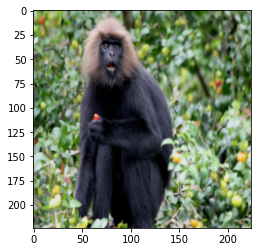

In [37]:
print('Predicted Label for one of the validation images: ', labels[0].cpu().detach().numpy())
plt.imshow(images[0].cpu().detach().numpy().transpose(1,2,0))
plt.show()
# We can verify that this image is indeed from n9 folder in the validation/validation directory of the Monkey Dataset